In [2]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt
import pickle

sys.path.insert(0, '..')

from function_space import DenseNet, DenseNet_tanh
from problems import ExponentialOnBallNonlinearSin
from solver import EllipticSolver
from utilities import plot_loss_logs_extended, plot_moving_average

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('../TD_Model_112922.pickle', 'rb') as f:
    model_td = pickle.load(f)

In [4]:
with open('../Diffusion_Model_112922.pickle', 'rb') as f:
    model_diff = pickle.load(f)

In [10]:
with open('../PINN_Model_112922.pickle', 'rb') as f:
    model_pinn = pickle.load(f)

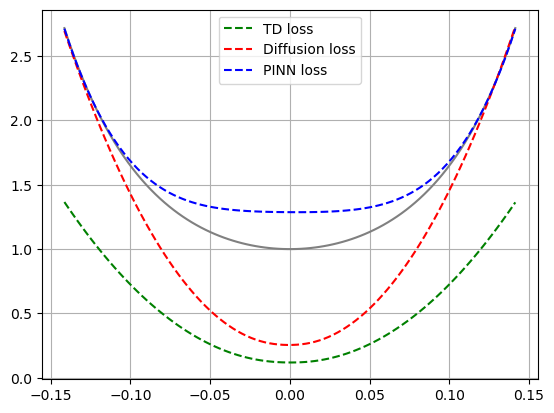

In [11]:
d = 50
L = 220000
print_every = 500
delta_t = 0.001
N = 20

problem = ExponentialOnBallNonlinearSin(d=d)

X = pt.cat([pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='gray')
plt.plot(X[:, 0].detach().cpu().numpy(), model_td.V(X).detach().cpu().numpy()[:, 0], '--', color='green', label='TD loss')
plt.plot(X[:, 0].detach().cpu().numpy(), model_diff.V(X).detach().cpu().numpy()[:, 0], '--', color='red', label='Diffusion loss')
plt.plot(X[:, 0].detach().cpu().numpy(), model_pinn.V(X).detach().cpu().numpy()[:, 0], '--', color='blue', label='PINN loss')
plt.grid()
plt.legend()
plt.show()